<a href="https://colab.research.google.com/github/shilpasy/Variant-Prioritization-miniproject-with-AlphaMissense-cBioPortal-and-ESM-models/blob/main/Tp53_Alpha_Missense_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Step : Extract TP53 Missense Annotations from AlphaMissense

# Mount Google Drive
from google.colab import drive
import pandas as pd
import gzip
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# file Paths
ALPHAMISSENSE_FILE = "/content/drive/MyDrive/AlphaMissense_ex/AlphaMissense_aa_substitutions.tsv.gz"
OUTPUT_FILE = "/content/drive/MyDrive/AlphaMissense_ex/TP53_AlphaMissense_Annotations.csv"
TEMP_FILE = "/content/drive/MyDrive/AlphaMissense_ex/TP53_Filtered_AlphaMissense.tsv.gz"

In [ ]:
# step 1 : Generate All Possible TP53 Missense Variants

tp53_uniprot_id = "P04637"  # UniProt ID for TP53 # # define TP53 reference sequence from (UniProt P04637)

tp53_wt_sequence = (
    "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGP"
    "DEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKS"
    "VSTSGEYRHVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIIITLEDSSGNLLG"
    "LPCVYIWGDYLPQEEQELREVAPRCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVV"
    "PYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIIITLEDSSGNLLGLPCVYIWGDYLP"
    "QEEQELREVAPRCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCT"
    "TIHYNYMCNSSCMGGMNRRPILTIIITLEDSSGNLLGLPCVYIWGDYLPQEEQELREVAPR"
    "CSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSC"
    "MGGMNRRPILTIIITLEDSSGNLLGLPCVYIWGDYLPQEEQELREVAP"
)

# define amino acid list
aa_list = "ACDEFGHIKLMNPQRSTVWY"

# generate all possible missense variants
missense_variants = []
for i, wt_aa in enumerate(tp53_wt_sequence):
    for mut_aa in aa_list:
        if mut_aa != wt_aa:  # avoid synonymous mutations
            variant = f"p.{wt_aa}{i+1}{mut_aa}"  # standard HGVS format
            missense_variants.append([wt_aa, i + 1, mut_aa, variant])

# covert this to df for easy handiling
tp53_df = pd.DataFrame(missense_variants, columns=["WT_AA", "Position", "Mut_AA", "Variant"])

tp53_variants_path = "/content/drive/MyDrive/AlphaMissense_ex/TP53_Missense_Variants.csv"
tp53_df.to_csv(tp53_variants_path, index=False)

In [ ]:
tp53_df.head()

,WT_AA,Position,Mut_AA,Variant
0,M,1,A,p.M1A
1,M,1,C,p.M1C
2,M,1,D,p.M1D
3,M,1,E,p.M1E
4,M,1,F,p.M1F


In [ ]:
tp53_df.tail()

,WT_AA,Position,Mut_AA,Variant
10160,P,535,S,p.P535S
10161,P,535,T,p.P535T
10162,P,535,V,p.P535V
10163,P,535,W,p.P535W
10164,P,535,Y,p.P535Y


In [ ]:
# step: extract TP53 data from alphamissense File
def extract_tp53_from_alphamissense(file_path, save_filtered=True):
    filtered_data = []

    with gzip.open(file_path, 'rt') as f:
        # skip non-data header lines
        for line in f:
            if "uniprot_id" in line:  # identify actual header
                header = line.strip().split('\t')
                print("✅ corrected Header:", header)
                break

        # identify column indexes
        uniprot_idx = header.index("uniprot_id")
        protein_variant_idx = header.index("protein_variant")
        pathogenicity_idx = header.index("am_pathogenicity")
        class_idx = header.index("am_class")

        for line in f:
            fields = line.strip().split('\t')
            if len(fields) < len(header):
                continue  # skipping malformed lines

            # extract fields
            uniprot_id = fields[uniprot_idx]
            protein_variant = fields[protein_variant_idx]
            am_pathogenicity = fields[pathogenicity_idx]
            am_class = fields[class_idx]

            # filter only TP53 (P04637) variants
            if uniprot_id == tp53_uniprot_id:
                filtered_data.append({
                    "UniProt_ID": uniprot_id,
                    "Variant": protein_variant,
                    "AlphaMissense_Pathogenicity": am_pathogenicity,
                    "AlphaMissense_Class": am_class
                })

    filtered_df = pd.DataFrame(filtered_data)

    if save_filtered and not filtered_df.empty:
        filtered_df.to_csv(TEMP_FILE, sep='\t', index=False, compression='gzip')
        print(f"✅ Filtered TP53 AlphaMissense data saved to: {TEMP_FILE}")

    return filtered_df

In [ ]:
# extract only TP53-related data from AlphaMissense # this step is taking 3-5 minutes
AM_aa_ss = extract_tp53_from_alphamissense(ALPHAMISSENSE_FILE)

✅ Corrected Header: ['uniprot_id', 'protein_variant', 'am_pathogenicity', 'am_class']
✅ Filtered TP53 AlphaMissense data saved to: /content/drive/MyDrive/AlphaMissense_ex/TP53_Filtered_AlphaMissense.tsv.gz


In [ ]:
AM_aa_ss

,UniProt_ID,Variant,AlphaMissense_Pathogenicity,AlphaMissense_Class
0,P04637,M1A,0.4065,ambiguous
1,P04637,M1C,0.511,ambiguous
2,P04637,M1D,0.8213,pathogenic
3,P04637,M1E,0.5521,ambiguous
4,P04637,M1F,0.3445,ambiguous
...,...,...,...,...
7462,P04637,D393S,0.3485,ambiguous
7463,P04637,D393T,0.6089,pathogenic
7464,P04637,D393V,0.5743,pathogenic
7465,P04637,D393W,0.9619,pathogenic


In [ ]:
# step: extract TP53 Annotations
def extract_tp53_annotations(alpha_df, tp53_variants):
    print("Columns in AlphaMissense Data:", alpha_df.columns)  # debugging: check actual column names

    # ensure variants match formatting (remove "p." from tp53_df)
    tp53_variants["Variant"] = tp53_variants["Variant"].str.replace("p.", "", regex=False)

    # merge with our generated TP53 missense list
    merged_df = tp53_variants.merge(alpha_df, on='Variant', how='left')

    return merged_df

In [ ]:
annotated_tp53 = extract_tp53_annotations(AM_aa_ss, tp53_df) # using the above function on tp53_df created earlier

Columns in AlphaMissense Data: Index(['UniProt_ID', 'Variant', 'AlphaMissense_Pathogenicity',
       'AlphaMissense_Class'],
      dtype='object')


In [ ]:
annotated_tp53.to_csv(OUTPUT_FILE, index=False)
print(f"Annotated TP53 variants saved to: {OUTPUT_FILE}")

Annotated TP53 variants saved to: /content/drive/MyDrive/AlphaMissense_ex/TP53_AlphaMissense_Annotations.csv


In [ ]:
annotated_tp53.head()

,WT_AA,Position,Mut_AA,Variant,UniProt_ID,AlphaMissense_Pathogenicity,AlphaMissense_Class
0,M,1,A,M1A,P04637,0.4065,ambiguous
1,M,1,C,M1C,P04637,0.511,ambiguous
2,M,1,D,M1D,P04637,0.8213,pathogenic
3,M,1,E,M1E,P04637,0.5521,ambiguous
4,M,1,F,M1F,P04637,0.3445,ambiguous


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=annotated_tp53)

https://docs.google.com/spreadsheets/d/1-DMqlbFTYc-j4QDdhVHi32JBAOZghHe21EzJZukJ5qo#gid=0


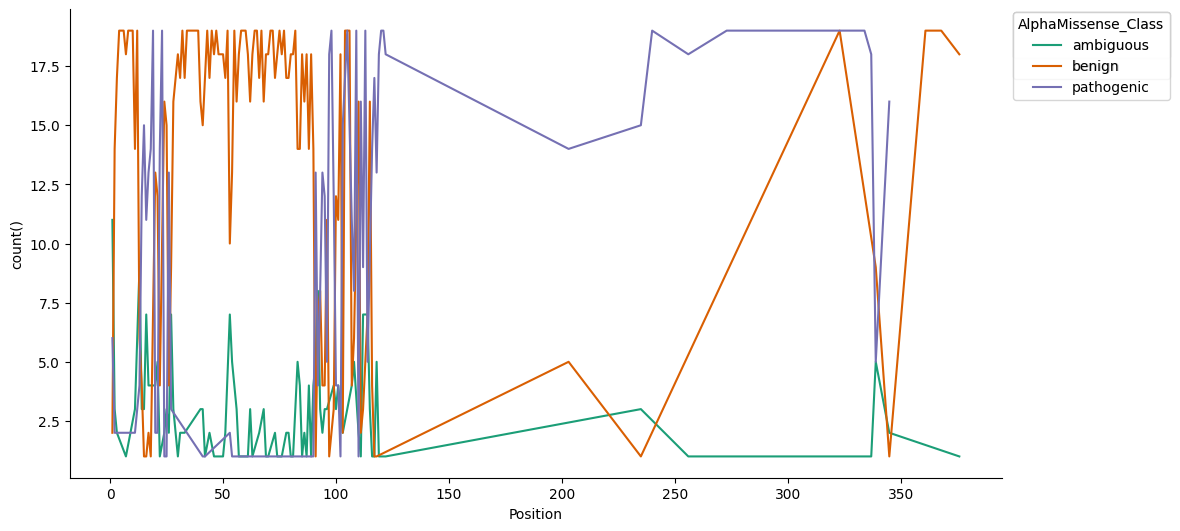

In [ ]:
# @title Position vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Position']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Position'}, axis=1)
              .sort_values('Position', ascending=True))
  xs = counted['Position']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = annotated_tp53.sort_values('Position', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('AlphaMissense_Class')):
  _plot_series(series, series_name, i)
  fig.legend(title='AlphaMissense_Class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Position')
_ = plt.ylabel('count()')

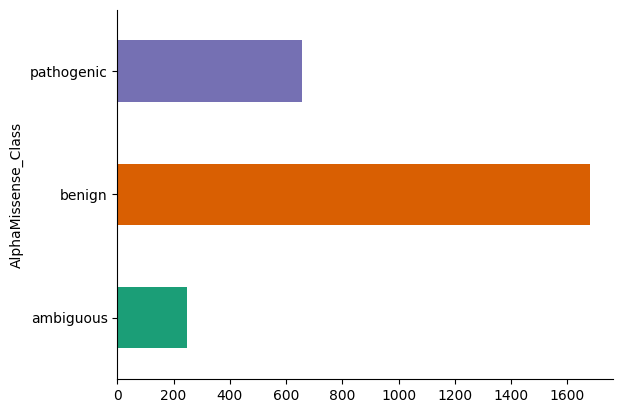

In [ ]:
# @title AlphaMissense_Class

from matplotlib import pyplot as plt
import seaborn as sns
annotated_tp53.groupby('AlphaMissense_Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)